**Sitzung 9**


---

Random Forests mit Gradio auf Basis des Titanik-Datensatzes:
Erstellung Random Forest für Wahrscheinlichkeit zu überleben und Generierung eines User Interfaces für das Wahrscheinlichkeitsmodell



Der Titanic-Datensatz ist auf github zu finden: https://github.com/datasciencedojo/datasets/blob/master/titanic.csv

Den Original-Code findet Ihr hier: https://github.com/gradio-app/gradio

Weitere Inputs zum Code stammen von https://deepnote.com/@leonard-puttmann/Titanic-Dataset-VExoGPeaQGi7wdb99C0pmA und https://colab.research.google.com/drive/1xOU3sDHs7yZjuBosbQ8Zb2oc4BegfSFX?usp=sharing#scrollTo=4hkjj1qMclUx


## 1. Import von Packages und Daten sowie Datenvorbereitung

Als erstes importieren wir die benötigten Packages. Da es sich bei der Gradio-App um eine Library handelt, welche seltener verwendet wird, ist diese nicht standardmäßig in Colab hinterlegt. Bevor wir sie **importieren** müssen wir sie daher **installieren**. Dies tun wir mit dem pip install Befehl:

In [1]:
!pip install -q gradio

In [ ]:
%pip install --upgrade gradio 

In [2]:
import gradio as gr
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Nun importieren wir den Datensatz und analysieren ihn kurz deskriptiv.

In [3]:
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vR1BhgC32RgNi4v8kh47UY9DzcgwUc4QSBkrwvu6nDzM-gPMH80nfqi026PWHohXMemtZhaNN3qa4sP/pub?output=csv')


In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
0,1,0,3,Mr. Owen Harris Braund,male,22.0,1,0,7.2500
1,2,1,1,Mrs. John Bradley (Florence Briggs Thayer) Cum...,female,38.0,1,0,71.2833
2,3,1,3,Miss. Laina Heikkinen,female,26.0,0,0,7.9250
3,4,1,1,Mrs. Jacques Heath (Lily May Peel) Futrelle,female,35.0,1,0,53.1000
4,5,0,3,Mr. William Henry Allen,male,35.0,0,0,8.0500


In [5]:
data.isnull().sum()

PassengerId                0
Survived                   0
Pclass                     0
Name                       0
Sex                        0
Age                        0
Siblings/Spouses Aboard    0
Parents/Children Aboard    0
Fare                       0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   PassengerId              887 non-null    int64  
 1   Survived                 887 non-null    int64  
 2   Pclass                   887 non-null    int64  
 3   Name                     887 non-null    object 
 4   Sex                      887 non-null    object 
 5   Age                      887 non-null    float64
 6   Siblings/Spouses Aboard  887 non-null    int64  
 7   Parents/Children Aboard  887 non-null    int64  
 8   Fare                     887 non-null    float64
dtypes: float64(2), int64(5), object(2)
memory usage: 62.5+ KB


In [7]:
data.describe()

,PassengerId,Survived,Pclass,Age,Siblings/Spouses Aboard,Parents/Children Aboard,Fare
count,887.000000,887.000000,887.000000,887.000000,887.000000,887.000000,887.00000
mean,444.000000,0.385569,2.305524,29.471443,0.525366,0.383315,32.30542
std,256.199141,0.487004,0.836662,14.121908,1.104669,0.807466,49.78204
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.00000
25%,222.500000,0.000000,2.000000,20.250000,0.000000,0.000000,7.92500
50%,444.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.45420
75%,665.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.13750
max,887.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.32920


## 2. Explorative Datenanalyse

Anschließend verschaffen wir uns einen grafischen Überblick.

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

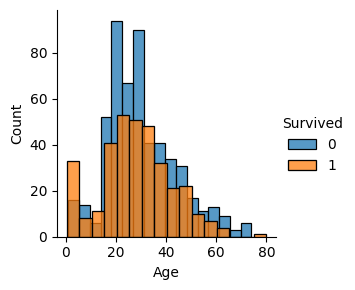

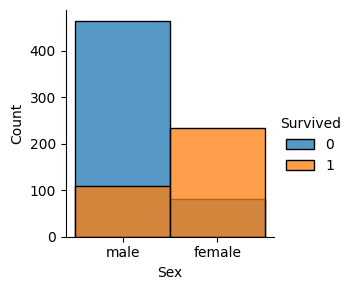

In [9]:
sns.FacetGrid(data,hue="Survived",height=3).map(sns.histplot,"Age").add_legend()
sns.FacetGrid(data,hue="Survived",height=3).map(sns.histplot,"Sex").add_legend()

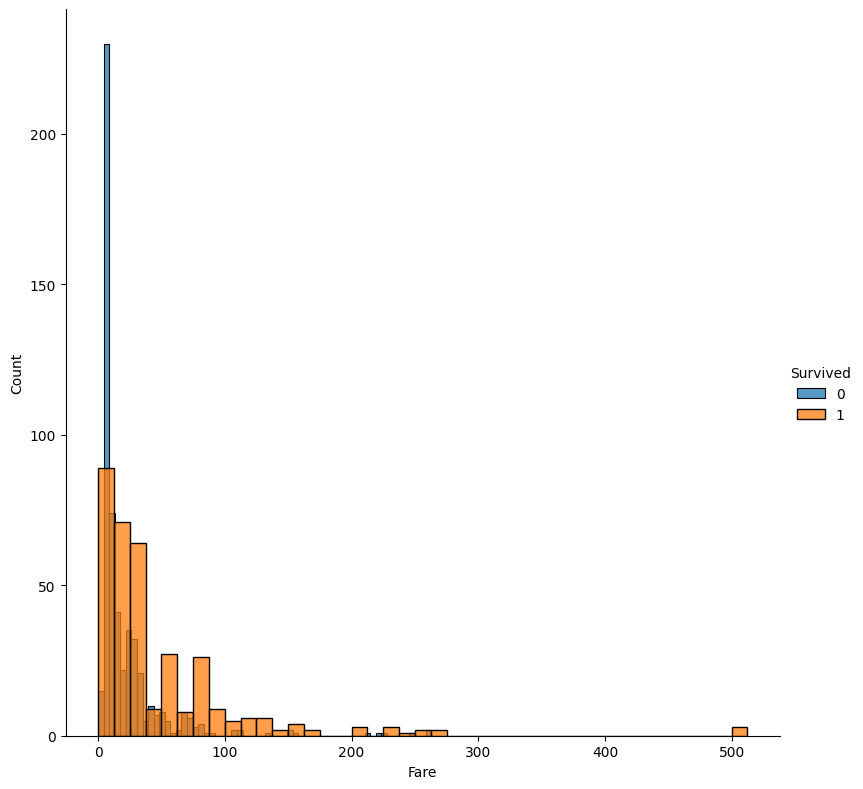

In [10]:
sns.FacetGrid(data,hue="Survived",height=8).map(sns.histplot,"Fare").add_legend()

plt.show()

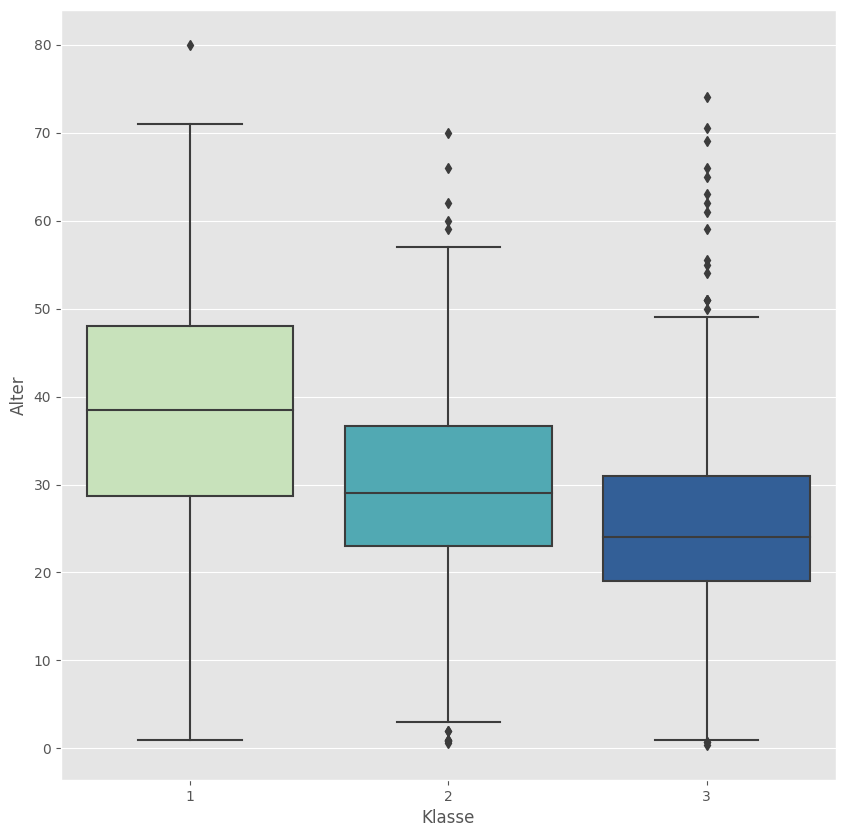

In [11]:
EDA_cols = ['Age', 'Pclass']
EDA_data = data[EDA_cols]

plt.figure(figsize=(10, 10))
plt.style.use('ggplot')
sns.boxplot(x='Pclass', y='Age', data=EDA_data, palette='YlGnBu')
plt.ylabel('Alter')
plt.xlabel('Klasse')
plt.show()

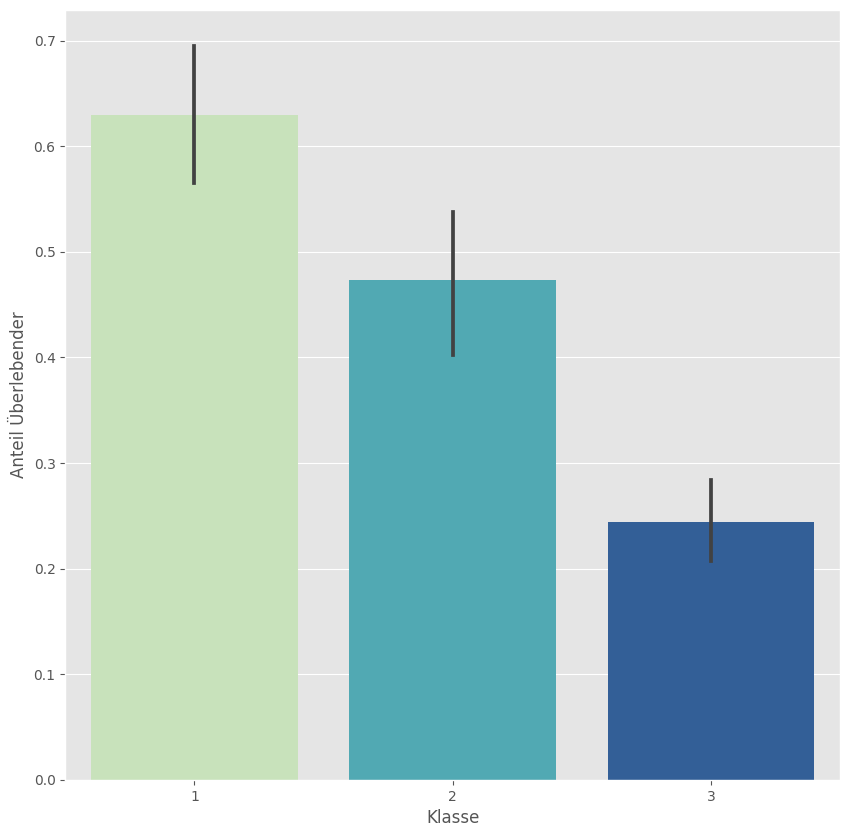

In [12]:
EDA_cols2 = ['Survived', 'Pclass']
EDA_data2 = data[EDA_cols2]

plt.style.use('ggplot')
plt.figure(figsize=(10, 10))
sns.barplot(x='Pclass', y='Survived', data=EDA_data2, palette='YlGnBu')
plt.ylabel('Anteil Überlebender')
plt.xlabel('Klasse')
plt.show()

Den grafisch dargestellten Eigenschaften des Datensatzes kann man sich auch mithilfe von Kreuztabellen annähern. Kreuztabellen dienen unter anderem dazu, sich die absolute Häufigkeit für den Zusammenhang zwischen zwei Variablen anzuzeigen.

In [13]:
# Create crosstab: ct
ct = pd.crosstab(data['Survived'], data['Pclass'])

# Display ct
print(ct)

Pclass      1   2    3
Survived              
0          80  97  368
1         136  87  119


In [14]:
# Create crosstab: ct
ct = pd.crosstab(data['Survived'], data['Sex'])

# Display ct
print(ct)

Sex       female  male
Survived              
0             81   464
1            233   109


## 3. Random Forests zur Berechnung der Überlebenswahrscheinlichkeit auf der Titanic

Nun erstellen wir Klassen, sogenannte bins, für Alter und Ticketpreise als Grundlage für die Entscheidungsbäume. "Bins" sind übersetzt Klassen, Eimer oder Reichweiten, in die man die Daten von einzelnen Features/Variablen unterteilt.

In [15]:
def encode_ages(df): # Binning ages
    df.Age = df.Age.fillna(-0.5)
    bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
    categories = pd.cut(df.Age, bins, labels=False)
    df.Age = categories
    return df

def encode_fares(df): # Binning fares
    df.Fare = df.Fare.fillna(-0.5)
    bins = (-1, 0, 8, 15, 31, 1000)
    categories = pd.cut(df.Fare, bins, labels=False)
    df.Fare = categories
    return df

def encode_sex(df):
    mapping = {"male": 0, "female": 1}
    return df.replace({'Sex': mapping})

Anschließend erstellen wir den Random Forest (=RF) mit 20% der Daten als Testsample und einem festgelegten RandomState von 23 um die Reproduzierbarkeit der Ergebnisse zu garantieren. Mehr zur Funktion des Random-State Parameters findet sich unter anderem hier: https://scikit-learn.org/stable/glossary.html#term-random_state

In [16]:
def transform_features(df):
    df = encode_ages(df)
    df = encode_fares(df)
    df = encode_sex(df)
    return df

train = data[['PassengerId', 'Sex', 'Age', 'Fare', 'Survived']]
train = transform_features(train)


X_all = train.drop(['Survived', 'PassengerId'], axis=1)
y_all = train['Survived']

num_test = 0.20
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, random_state=23)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print("accuracy: ", accuracy_score(y_test, predictions))

accuracy:  0.8033707865168539


Die Genauigkeit (accuracy) des RF für das Testsample liegt bei rund 80%. Die Genauigkeit bezeichnet den Anteil der korrekten Vorhersagen am Gesamtteil der Vorhersagen. Dazu mehr hier: https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score

Nachdem wir das Modell trainiert haben, definieren wir nun die Vorhersagefunktion für die Berechnung der Wahrscheinlichkeit zu überleben. Die Kategorien der binären abhängigen (zu erklärenden) Variable sind "überleben" und "sterben".

In [17]:
def predict_survival(sex, age, fare):
    df = pd.DataFrame.from_dict({'Sex': [sex], 'Age': [age], 'Fare': [fare]})
    df = encode_sex(df)
    df = encode_fares(df)
    df = encode_ages(df)
    pred = clf.predict_proba(df)[0]
    return {'Perishes': pred[0], 'Survives': pred[1]}

## 4. Weitere Aufgaben



---


Abschließend erstellen wir das Userinterface, das es ermöglicht, über Modifikation der Kriterien "Geschlecht", "Alter" und "Ticketpreis" die Wahrscheinlichkeit für "überleben" oder "sterben" auf Basis des Random Forest zu ermitteln.

In [18]:
sex = gr.Dropdown(['male', 'female'], label="Sex")
age = gr.Slider(minimum=0, maximum=120, value=22, label="Age")
fare = gr.Slider(minimum=0, maximum=1000, value=100, label="Fare (british pounds)")

In [19]:
port = 8080

Vor dem Start der App stellen wir sicher, dass keine Apps laufen, welche die Nutzung des Ports blockieren könnten:

In [20]:
gr.close_all()

In [21]:
root_path = f"/studiolab/default/jupyter/proxy/{port}"

In [22]:
demo = gr.Interface(predict_survival, [sex, fare, age], "label")

In [23]:
demo.launch(server_port=8080, root_path=root_path, inline=False)

OSError: Cannot find empty port in range: 8080-8080. You can specify a different port by setting the GRADIO_SERVER_PORT environment variable or passing the `server_port` parameter to `launch()`.

Zur Erstellung des Links müssen Sie ihre eigenen Studio-Lab-Domain kopieren:
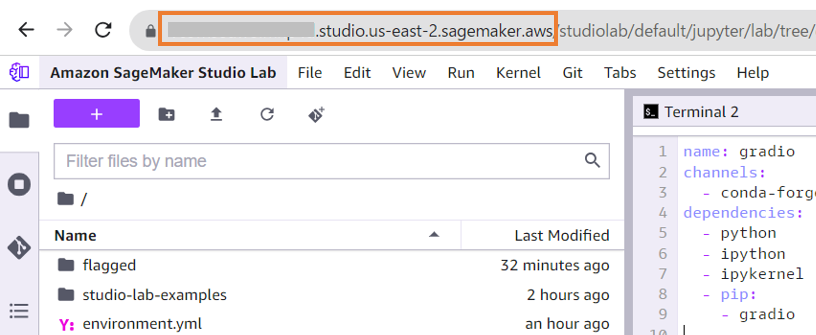

In [ ]:
lab_domain = "pxg8xyrynq3mpag.studio.us-east-2.sagemaker.aws"

In [ ]:
print(f"Please access https://{lab_domain}/studiolab/default/jupyter/proxy/{port}/")

Unglücklicherweise gibt es bei dem letzten Schritt ein Problem, weswegen wir uns die App offline ansehen werden.